# TAREFA: Base de dados CIFAR-10

Nas aulas anteriores você aprendeu como utilizar a base de dados MNIST para classificação de dígitos escritos a mão. Além dela, outra base de dados bastante famosa é a CIFAR-10, que é utilizada para classificação de 10 classes, ou seja: avião, automóvel, pássaro, gato, veado, cachorro, sapo, cavalo, navio e caminhão. Clicando no link abaixo você pode ver mais detalhes sobre ela

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)

Utilizando esta base de dados, o objetivo é você construir uma rede neural conforme desenvolvemos nas aulas sobre o MNIST, avaliando os percentuais de acerto que você obterá testando diversas configurações com a rede neural convolucional. No link abaixo você pode verificar quais foram os percentuais máximos de acerto atingidos por outros pesquisadores

[Acertos base CIFAR-10](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130)

Siga as seguintes dicas para concluir esta tarefa:

- Consulte a [documentação](https://pytorch.org/docs/stable/index.html) do PyTorch para aprender como carregar essa base de dados

- A dimensão das imagens é 32 x 32 e elas são coloridas, portanto, você deve fazer esses ajustes no código fonte

- Quando avaliamos algoritmos de aprendizagem de máquina, o ideal é utilizar validação cruzada. Porém, para não aumentarmos o tempo de processamento, você pode utilizar as bases de treinamento e teste para esta tarefa

In [1]:
!pip install torch==1.4.0 torchvision==0.5.0

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 53.7MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


## Etapa 1: Importação das Bibliotecas

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


## Etapa 2: Base de dados

In [3]:
torch.manual_seed(123)

In [4]:
"""transform_train = transforms.Compose([
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(degrees=7,
                                                              translate=(0,0.07),
                                                              shear=7,
                                                              scale=(1,1.2)),
                                      transforms.ToTensor()
])"""

'transform_train = transforms.Compose([\n                                      transforms.RandomHorizontalFlip(),\n                                      transforms.RandomAffine(degrees=7,\n                                                              translate=(0,0.07),\n                                                              shear=7,\n                                                              scale=(1,1.2)),\n                                      transforms.ToTensor()\n])'

In [5]:
#transform_test = transforms.ToTensor()
transform = transforms.ToTensor()

In [6]:
train = datasets.CIFAR10(root='.', train=True, download=True, transform=transform)
test = datasets.CIFAR10(root='.', train=False, download=True, transform=transform)

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [7]:
train.data[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [8]:
train.data.shape

(50000, 32, 32, 3)

In [9]:
train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

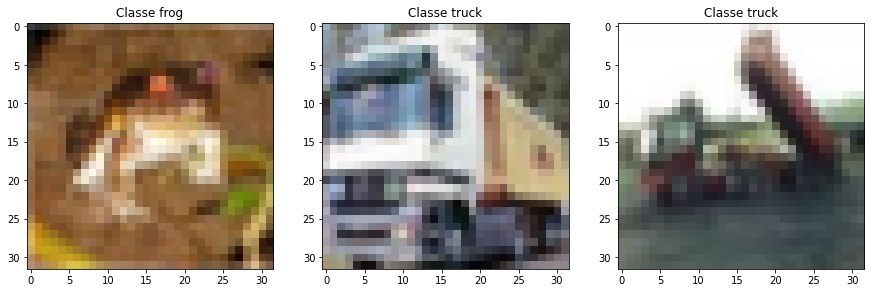

In [10]:
_, ax = plt.subplots(1,3, figsize=(15,6))
for i in range(3):
  img = train.data[i]
  ax[i].imshow(img)
  ax[i].set_title('Classe '+ str(train.classes[train.targets[i]]))
plt.show()

In [11]:
train_loader = torch.utils.data.DataLoader(train, batch_size=128)
test_loader = torch.utils.data.DataLoader(test, batch_size=128)

## Etapa 3: Construção do modelo

In [12]:
class cls_torch(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3))
    self.conv2 = nn.Conv2d(32,32,(3,3))
    
    self.activation1 = nn.ReLU()
    self.activation2 = nn.GELU()

    self.bnorm = nn.BatchNorm2d(num_features=32)
    self.pool = nn.MaxPool2d(kernel_size=(2,2))
    self.flatten = nn.Flatten()

    # output = (input - filter + 1) / stride
    # Convolução 1: (32 - 3 + 1) / 1 = 30 => img(30px X 30px)
    # Pooling 1: kernel_size=(2,2) => 30 / 2, 30 / 2 => img(15px X 15px)
    # Convolução 2: (15 - 3 + 1) / 1 = 13 => img(13px X 13px)
    # Pooling 2: kernel_size=(2,2) => 13 / 2, 13 / 2 => img(6px X 6px)
    # Saída Pooling 2 = 6 * 6 * 32 (BatchNorm2d(num_features=32))
    # 1152 -> 128

    self.linear1 = nn.Linear(in_features=32*6*6, out_features=512)
    self.linear2 = nn.Linear(512,512)
    self.linear3 = nn.Linear(512,256)
    self.linear4 = nn.Linear(256,256)
    self.linear5 = nn.Linear(256,128)
    self.linear6 = nn.Linear(128,128)
    self.output = nn.Linear(128,10)
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, X):
        X = self.pool(self.bnorm(self.activation1(self.conv1(X))))
        X = self.pool(self.bnorm(self.activation2(self.conv2(X))))
        X = self.flatten(X)
        
        X = self.dropout(self.activation1(self.linear1(X)))
        X = self.dropout(self.activation2(self.linear2(X)))
        X = self.dropout(self.activation1(self.linear3(X)))
        X = self.dropout(self.activation2(self.linear4(X)))
        X = self.dropout(self.activation1(self.linear5(X)))
        X = self.dropout(self.activation2(self.linear6(X)))
        X = self.output(X)

        return X

In [13]:
net = cls_torch()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

## Etapa 4: Treinamento do modelo

In [14]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [15]:
net.to(device)

cls_torch(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation1): ReLU()
  (activation2): GELU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (linear1): Linear(in_features=1152, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=128, bias=True)
  (linear6): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [16]:
def training_loop(loader, epoch):

  running_loss = 0.
  running_acc = 0.

  for i, data in enumerate(loader):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = net(inputs)
    top_p, top_class = outputs.topk(k=1,dim=1)
    equals = top_class == labels.view(*top_class.shape)

    acc = torch.mean(equals.type(torch.float))
    running_acc += acc

    loss = criterion(outputs, labels)
    loss.backward()

    optimizer.step()

    running_loss += loss.item()
    # Imprimindo os dados referentes a esse loop
    print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}'\
          .format(epoch + 1, i + 1, len(loader), loss, acc), end = '\r')

  # Imprimindo os dados referentes a essa época
  print('\rÉPOCA {:3d} FINALIZADA: perda {:.5f} - precisão {:.5f}\n'\
        .format(epoch + 1, running_loss/len(loader), running_acc/len(loader)))


In [17]:
for epoch in range(10):
    print('Treinando...')
    training_loop(train_loader, epoch)

    net.eval()
    print('Validando...')
    training_loop(test_loader, epoch)

    net.train()

Treinando...
ÉPOCA   1 FINALIZADA: perda 1.52540 - precisão 0.43564

Validando...
ÉPOCA   1 FINALIZADA: perda 1.74136 - precisão 0.38865

Treinando...
ÉPOCA   2 FINALIZADA: perda 1.12237 - precisão 0.61412

Validando...
ÉPOCA   2 FINALIZADA: perda 1.31978 - precisão 0.53738

Treinando...
ÉPOCA   3 FINALIZADA: perda 0.94212 - precisão 0.68635

Validando...
ÉPOCA   3 FINALIZADA: perda 1.19536 - precisão 0.57803

Treinando...
ÉPOCA   4 FINALIZADA: perda 0.80163 - precisão 0.73316

Validando...
ÉPOCA   4 FINALIZADA: perda 1.05070 - precisão 0.64023

Treinando...
ÉPOCA   5 FINALIZADA: perda 0.69348 - precisão 0.76988

Validando...
ÉPOCA   5 FINALIZADA: perda 0.94785 - precisão 0.67929

Treinando...
ÉPOCA   6 FINALIZADA: perda 0.60946 - precisão 0.79779

Validando...
ÉPOCA   6 FINALIZADA: perda 0.85668 - precisão 0.71015

Treinando...
ÉPOCA   7 FINALIZADA: perda 0.54873 - precisão 0.82065

Validando...
ÉPOCA   7 FINALIZADA: perda 0.79237 - precisão 0.73863

Treinando...
ÉPOCA   8 FINALIZADA: